In [98]:
import torch
import torchvision
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
import shutil

from sympy.strategies.core import switch

from approx_attributes import *
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from huggingface_hub import hf_hub_download
from torch.utils.data import DataLoader
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import InputXGradient,IntegratedGradients,Saliency
print(torch.__version__)
print(torchvision.__version__)

2.7.1+cu126
0.22.1+cu126


In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = torch.load("resnet18_cifar10_32x32_epoch30.pth",weights_only=False)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
#model.to(device)
#model.eval()

In [101]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # 32x32x32 -> 16x16x32 (nach MaxPool)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 16x16x64 -> 8x8x64 (nach MaxPool)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*8*8, 256)  # 64*8*8 = 4096
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Input: 32x32x3
        x = F.relu(self.conv1(x))                      # -> 32x32x32
        x = F.relu(self.conv2(x))                      # -> 32x32x32
        x = F.max_pool2d(x, 2)                         # -> 16x16x32
        x = F.relu(self.conv3(x))                      # -> 16x16x64
        x = F.max_pool2d(x, 2)                         # -> 8x8x64
        x = self.flatten(x)                            # -> 4096
        x = F.relu(self.fc1(x))                        # -> 256
        x = self.fc2(x)                                # -> 10
        return x

def train_one_epoch(model, dataloader, optimizer, device):
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    i = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        print(i)
        i +=1
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #print(f"output: {output} target: {target}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    print(f'Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

if os.path.isfile("CifarModelCnn.pth"):

    state_dict = torch.load("CifarModelCnn.pth", map_location=torch.device(device))

    model.load_state_dict(state_dict)
    model.eval()
else:

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for x in range(10):
        train_one_epoch(model, train_loader, optimizer, device)
    torch.save(model.state_dict(), "CifarModelCnn.pth")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [67]:
"""
model2 = models.resnet18(num_classes=10)

model2.load_state_dict(torch.load("resnet18_cifar10.pth", map_location="cpu"))
model2.to(device)
model2.eval()

model3 = models.resnet50(weights=None, num_classes=10)
model3.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model3.maxpool = nn.Identity()


weights_path = hf_hub_download(repo_id="edadaltocg/resnet50_cifar10", filename="pytorch_model.bin")
state_dict = torch.load(weights_path, map_location="cpu")
model3.load_state_dict(state_dict)
model3.to(device)
model3.eval()

"""

'\nmodel2 = models.resnet18(num_classes=10)\n\nmodel2.load_state_dict(torch.load("resnet18_cifar10.pth", map_location="cpu"))\nmodel2.to(device)\nmodel2.eval()\n\nmodel3 = models.resnet50(weights=None, num_classes=10)\nmodel3.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)\nmodel3.maxpool = nn.Identity()\n\n\nweights_path = hf_hub_download(repo_id="edadaltocg/resnet50_cifar10", filename="pytorch_model.bin")\nstate_dict = torch.load(weights_path, map_location="cpu")\nmodel3.load_state_dict(state_dict)\nmodel3.to(device)\nmodel3.eval()\n\n'

In [68]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

dataset = test_loader.dataset
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [69]:
def to_numpy_image(attr):
    """
    Bringt Attribution Map in Shape (H,W,C) für matplotlib.
    Erwartet Tensor oder numpy array in Form:
    - (C,H,W)
    - (H,W,C)
    - (3072,)
    - (1,C,H,W)
    """
    if isinstance(attr, torch.Tensor):
        attr = attr.detach().cpu().numpy()

    if attr.ndim == 1:  # flach: 3072
        attr = attr.reshape(3, 32, 32)

    if attr.ndim == 4:  # Batch-Format
        attr = attr.squeeze(0)  # -> (C,H,W)

    if attr.shape[0] == 3 and attr.ndim == 3:  # (C,H,W)
        attr = np.transpose(attr, (1, 2, 0))

    return attr

Grad Approx


/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3199205..2.514088].
/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3199205..2.514088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for

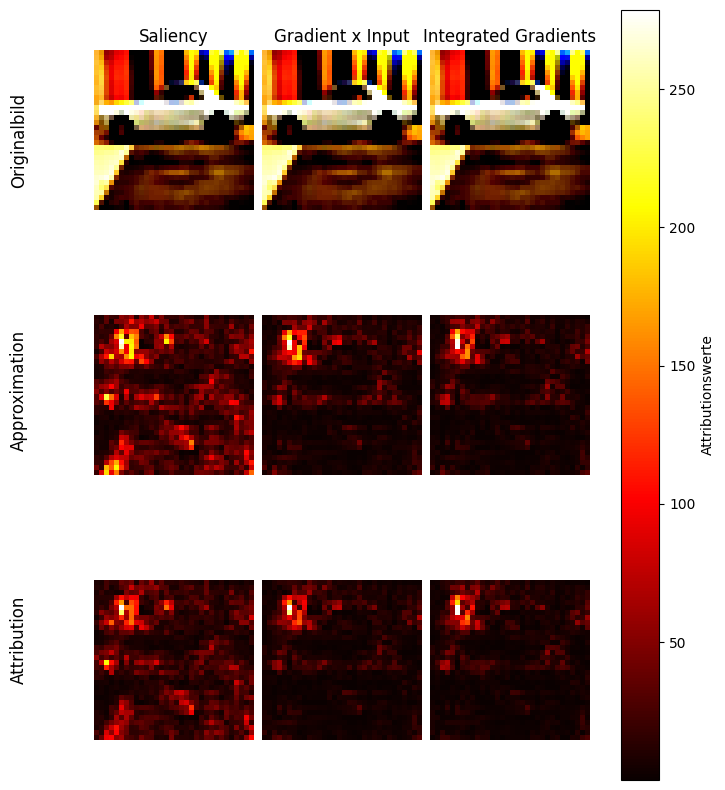

In [96]:

model = model
aa = ApproxAttribution(model)
sal = Saliency(model)
IxG = InputXGradient(model)
ig = IntegratedGradients(model)

idx = np.random.randint(0, len(dataset) - 1)

plt.style.use('default')

fig, axes = plt.subplots(3, 3, figsize=(8,10))
fig.set_facecolor('white')

axes[0, 0].set_title('Saliency')
axes[0, 1].set_title('Gradient x Input')
axes[0, 2].set_title('Integrated Gradients')

fig.text(0.02, 0.75, 'Originalbild', rotation=90, verticalalignment='center',fontsize=12)
fig.text(0.02, 0.5, 'Approximation', rotation=90, verticalalignment='center',fontsize=12)
fig.text(0.02, 0.25, 'Attribution', rotation=90, verticalalignment='center',fontsize=12)

cnt = 0
for i in range(3):
    img, label = dataset[idx]

    #attribution_map_real = ig.attribute(img.unsqueeze(0).float(), target=label,baselines=torch.zeros_like(img, dtype=torch.float)).detach().numpy()
    #attribution_map = to_numpy_image(aa.grad_approx(0.1,[img.unsqueeze(0)],label))
    #attribution_map_real = to_numpy_image(sal.attribute(img.unsqueeze(0).float().to(device), target=label))

    if i == 0:
        attribution_map = aa.grad_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = sal.attribute(img.unsqueeze(0).float().to(device), target=label)
    elif i == 1:
        attribution_map = aa.grad_x_i_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = IxG.attribute(img.unsqueeze(0).float().to(device), target=label)
    elif i == 2:
        attribution_map = aa.int_grad_approx(0.1, [img.unsqueeze(0)], target=label).reshape(3, 32, 32)
        attribution_map_real = ig.attribute(img.unsqueeze(0).float().to(device), target=label,baselines=torch.zeros_like(img.unsqueeze(0), dtype=torch.float).to(device)) #.detach().cpu().numpy()


    attribution_map_real = attribution_map_real.squeeze().detach().cpu().numpy()  # shape: [3, # 32, 32]

    attr_vis = np.abs(attribution_map).max(axis=0)
    attr_real_vis = np.abs(attribution_map_real).max(axis=0)

    image_np = to_numpy_image(img)

    im = axes[0,i].imshow(image_np)
    axes[0,i].axis('off')

    im1 = axes[1,i].imshow(attr_vis, cmap='hot')
    axes[1,i].axis('off')

    im2 = axes[2,i].imshow(attr_real_vis, cmap='hot')
    axes[2,i].axis('off')

    cnt = cnt + 1

plt.subplots_adjust(wspace=0.05, hspace=0.1)
fig.colorbar(im1, ax=axes.ravel().tolist(), label='Attributionswerte')
#plt.tight_layout()
plt.savefig("mein_plot.png", bbox_inches='tight')
plt.show()


In [71]:
"""
high = 1.0
medium = 0.1
low = 1e-4





"""

'\nhigh = 1.0\nmedium = 0.1\nlow = 1e-4\n\n\n\n\n\n'

In [72]:
high = 1.0
mediumhigh = 0.5
medium = 0.01
low = 1e-4

def gen_data(h=high,method="Sal",filename="daten_sal.npz",size=10,baseline=None,model=model):
    aa = ApproxAttribution(model)
    sal = Saliency(model)
    IxG = InputXGradient(model)
    ig = IntegratedGradients(model)

    real = []
    approx = []
    idx =[]
    for i in range(size):
        idx.append(np.random.randint(0, len(dataset) - 1))

    for i in idx:
        img, label = dataset[i]
        if method == "Sal":
            approx.append(aa.grad_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            real.append(sal.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())
        if method == "GxI":
            approx.append(aa.grad_x_i_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            real.append(IxG.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())
        if method == "Int":
            approx.append(aa.int_grad_approx(h, [img.unsqueeze(0)], target=label).reshape(3, 32, 32))
            real.append(ig.attribute(img.unsqueeze(0).float().to(device), target=label).squeeze().detach().cpu().numpy())

    real_flat = [np.array(r).flatten() for r in real]
    approx_flat = [np.array(a).flatten() for a in approx]


    real_flat = np.array(real_flat)
    approx_flat = np.array(approx_flat)
    np.savez(filename, arr1=real_flat,arr2=approx_flat)

#gen_data(h=high,method="Int",filename="ResNet50_Int_20_high.npz",size=20,model=model3)

In [73]:
#gen_data(h=mediumhigh,method="Int",filename="ResNet50_Int_20_mediumhigh.npz",size=20,model=model3)

In [74]:
#gen_data(h=high,method="GxI",filename="ResNet50_GxI_50_high.npz",size=50,model=model3)
#gen_data(h=mediumhigh,method="GxI",filename="ResNet50_GxI_50_mediumhigh.npz",size=50,model=model3)

In [75]:
#gen_data(h=low,method="Sal",filename="ResNet50_Sal_50_low.npz",size=50,model=model3)
#gen_data(h=medium,method="Sal",filename="ResNet50_Sal_50_medium.npz",size=50,model=model3)
#gen_data(h=high,method="Sal",filename="ResNet50_Sal_50_high.npz",size=50,model=model3)
#gen_data(h=mediumhigh,method="Sal",filename="ResNet50_Sal_50_mediumhigh.npz",size=50,model=model3)

In [76]:
#gen_data(h=low,method="GxI",filename="ResNet18_GxI_50_low.npz",size=50,model=model2)
#gen_data(h=medium,method="GxI",filename="ResNet18_GxI_50_medium.npz",size=50,model=model2)
#gen_data(h=mediumhigh,method="GxI",filename="ResNet18_GxI_50_mediumhigh.npz",size=50,model=model2)
#gen_data(h=high,method="GxI",filename="ResNet18_GxI_50_high.npz",size=50,model=model2)

In [77]:
#gen_data(h=low,method="Sal",filename="ResNet18_Sal_50_low.npz",size=50,model=model2)
#gen_data(h=medium,method="Sal",filename="ResNet18_Sal_50_medium.npz",size=50,model=model2)
#gen_data(h=mediumhigh,method="Sal",filename="ResNet18_Sal_50_mediumhigh.npz",size=50,model=model2)
#gen_data(h=high,method="Sal",filename="ResNet18_Sal_50_high.npz",size=50,model=model2)

In [78]:
#gen_data(h=low,method="Int",filename="CNN_Int_20_low.npz",size=20,model=model)
#gen_data(h=medium,method="Int",filename="CNN_Int_20_medium.npz",size=20,model=model)
#gen_data(h=mediumhigh,method="Int",filename="CNN_Int_20_mediumhigh.npz",size=20,model=model)
#gen_data(h=high,method="Int",filename="CNN_Int_20_high.npz",size=20,model=model)

In [79]:
#gen_data(h=low,method="GxI",filename="CNN_GxI_50_low.npz",size=50,model=model)
#gen_data(h=medium,method="GxI",filename="CNN_GxI_50_medium.npz",size=50,model=model)
gen_data(h=5e-5,method="GxI",filename="CNN_GxI_20_5e-5.npz",size=20,model=model)
#gen_data(h=high,method="GxI",filename="CNN_GxI_50_high.npz",size=50,model=model)

#gen_data(h=low,method="Sal",filename="CNN_Sal_50_low.npz",size=50,model=model)
#gen_data(h=medium,method="Sal",filename="CNN_Sal_50_medium.npz",size=50,model=model)
#gen_data(h=mediumhigh,method="Sal",filename="CNN_Sal_50_mediumhigh.npz",size=50,model=model)
#gen_data(h=high,method="Sal",filename="CNN_Sal_50_high.npz",size=50,model=model)

/home/benomin/PycharmProjects/BA-Approximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


In [80]:
####################################################################################################
#gen_data(h=low,method="Int",filename="ResNet18_Int_20_low.npz",size=20,model=model2)
#gen_data(h=medium,method="Int",filename="ResNet18_Int_20_medium.npz",size=20,model=model2)
#gen_data(h=mediumhigh,method="Int",filename="ResNet18_Int_20_mediumhigh.npz",size=20,model=model2)
#gen_data(h=high,method="Int",filename="ResNet18_Int_20_high.npz",size=20,model=model2)
####################################################################################################

In [81]:
from captum.attr import InputXGradient,IntegratedGradients,Saliency
from scipy import stats
from approx_attributes import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity


data = np.load("ResNet50_Int_20_medium.npz")
real = data["arr1"]
approx = data["arr2"]
print(real.shape)
print("Pearson-Correlation:",np.mean(np.corrcoef(real,approx)))
roh,p = stats.spearmanr(real.ravel(), approx.ravel())
print("Rank-Correlation:",roh)
print("Gesamt-MSE:", mean_squared_error(real,approx))
cos_total = cosine_similarity(real, approx)
print("Gesamt-Cosine Similarity:", cos_total)

(20, 3072)
Pearson-Correlation: 0.04521190585910793
Rank-Correlation: 0.9110776552075542
Gesamt-MSE: 0.02908332087099552
Gesamt-Cosine Similarity: [[ 9.75825906e-01 -6.15905225e-02  3.77172939e-02  8.04384276e-02
  -2.38715634e-02  2.89995950e-02 -1.17279720e-02  2.93049566e-03
   3.94096524e-02  2.41789222e-02  4.21807263e-03  6.56839693e-03
  -7.40701053e-03  6.77203573e-03  7.19675645e-02 -2.73624882e-02
  -3.88229080e-02 -2.23604161e-02 -1.23510454e-02  2.03803293e-02]
 [-9.01859626e-02  8.85672927e-01  5.06275427e-03  1.39300618e-02
   1.63417943e-02 -7.30300918e-02 -5.16112521e-02 -2.12611631e-02
  -4.36526872e-02  8.18971545e-02  3.05864145e-04 -6.78773150e-02
   5.90675883e-02 -4.44339253e-02 -3.40971872e-02 -2.72924919e-02
   1.39328558e-03  5.63541800e-02  7.41459504e-02 -1.84828117e-02]
 [ 3.17390896e-02 -2.87307729e-03  9.55353141e-01  1.92301217e-02
  -4.10260409e-02  2.81814951e-02 -2.69164480e-02 -6.57443050e-03
  -1.58562157e-02 -2.68728007e-02  7.50161428e-03  1.649111

(20, 3072)


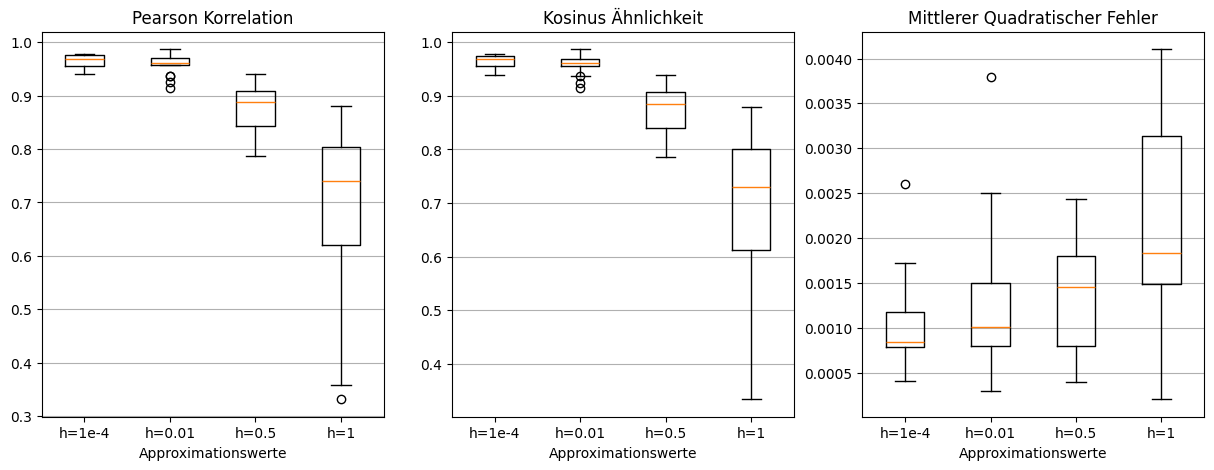

In [97]:
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

data_low = np.load("ResNet18_Int_20_low.npz")
data_medium = np.load("ResNet18_Int_20_medium.npz")
data_mediumhigh = np.load("ResNet18_Int_20_mediumhigh.npz")
data_high = np.load("ResNet18_Int_20_high.npz")

reall = data_low["arr1"]
approxl = data_low["arr2"] #*-1

realm = data_medium["arr1"]
approxm = data_medium["arr2"]#*-1

realmh = data_mediumhigh["arr1"]
approxmh = data_mediumhigh["arr2"]#*-1

realh = data_high["arr1"]
approxh = data_high["arr2"]#*-1

print(real.shape)  # (10, 30720)

# Listen, um Ergebnisse zu speichern
pearson_listl = []
mse_listl = []
cosine_listl = []

pearson_listm = []
mse_listm = []
cosine_listm = []

pearson_listmh = []
mse_listmh = []
cosine_listmh = []

pearson_listh = []
mse_listh = []
cosine_listh = []

for i in range(reall.shape[0]):
    rl = reall[i]
    al = approxl[i]

    rm = realm[i]
    am = approxm[i]

    rmh = realmh[i]
    amh = approxmh[i]

    rh = realh[i]
    ah = approxh[i]

    # Pearson-Korrelation
    pearson = np.corrcoef(rl, al)[0, 1]
    pearson_listl.append(pearson)

    pearson = np.corrcoef(rm, am)[0, 1]
    pearson_listm.append(pearson)

    pearson = np.corrcoef(rmh, amh)[0, 1]
    pearson_listmh.append(pearson)

    pearson = np.corrcoef(rh, ah)[0, 1]
    pearson_listh.append(pearson)


    # MSE
    mse = mean_squared_error(rl, al)
    mse_listl.append(mse)

    mse = mean_squared_error(rm, am)
    mse_listm.append(mse)

    mse = mean_squared_error(rmh, amh)
    mse_listmh.append(mse)

    mse = mean_squared_error(rh, ah)
    mse_listh.append(mse)


    # Cosine Similarity
    cos = cosine_similarity(rl.reshape(1, -1), al.reshape(1, -1))[0, 0]
    cosine_listl.append(cos)

    cos = cosine_similarity(rm.reshape(1, -1), am.reshape(1, -1))[0, 0]
    cosine_listm.append(cos)

    cos = cosine_similarity(rmh.reshape(1, -1), amh.reshape(1, -1))[0, 0]
    cosine_listmh.append(cos)

    cos = cosine_similarity(rh.reshape(1, -1), ah.reshape(1, -1))[0, 0]
    cosine_listh.append(cos)

# Ausgabe

#for i in range(real.shape[0]):
#    print(f"Sample {i}: Pearson={pearson_list[i]:.4f}, Spearman={spearman_list[i]:.4f}, MSE={mse_list[i]:.4f},
#Cosine={cosine_list[i]:.4f}")

fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Pearson
axs[0].boxplot([pearson_listl,pearson_listm,pearson_listmh,pearson_listh])
axs[0].set_title('Pearson Korrelation')

axs[0].yaxis.grid(True)
axs[0].set_xticks([y + 1 for y in range(4)],
                labels=['h=1e-4', 'h=0.01', 'h=0.5', 'h=1'])
axs[0].set_xlabel('Approximationswerte')



# Cosine
axs[1].boxplot([cosine_listl,cosine_listm,cosine_listmh,cosine_listh])
axs[1].set_title('Kosinus Ähnlichkeit')

axs[1].yaxis.grid(True)
axs[1].set_xticks([y + 1 for y in range(4)],
                labels=['h=1e-4', 'h=0.01', 'h=0.5', 'h=1'])
axs[1].set_xlabel('Approximationswerte')



# MSE
axs[2].boxplot([mse_listl,mse_listm,mse_listmh,mse_listh])
axs[2].set_title('Mittlerer Quadratischer Fehler')

axs[2].yaxis.grid(True)
axs[2].set_xticks([y + 1 for y in range(4)],
                labels=['h=1e-4', 'h=0.01', 'h=0.5', 'h=1'])
axs[2].set_xlabel('Approximationswerte')



plt.savefig("Boxplot.png", bbox_inches='tight')
plt.show()

In [93]:
data_low = np.load("CNN_GxI_50_low.npz")
data_medium = np.load("ResNet18_GxI_50_medium.npz")
data_high = np.load("ResNet50_GxI_50_high.npz")

realCNN = data_low["arr1"]

realResNet18 = data_medium["arr1"]

realResNet50 = data_high["arr1"]


print("CNN min:",np.min(realCNN))
print("CNN max:",np.max(realCNN))

print("ResNet18 min:",np.min(realResNet18))
print("ResNet18 max:",np.max(realResNet18))

print("ResNet50 min:",np.min(realResNet50))
print("ResNet50 max:",np.max(realResNet50))

CNN min: -613.866
CNN max: 908.1349
ResNet18 min: -0.88134
ResNet18 max: 1.1079017
ResNet50 min: -10.350835
ResNet50 max: 13.611308
